In [7]:
import pandas as pd
pd.read_pickle(f'../output/data_20250219130618.pkl')

고객ID   나이  성별  수익자여부  두낫콜여부     운전코드명 성별코드  피보험자여부  보험연령  \
0        25226  60대  여성      1    1.0  승용차(자가용)   02       1    66   
1        95256  40대  남성      1    0.0  화물차(자가용)   02       1    42   
2        14751  40대  여성      1    1.0       NaN   02       1    49   
3         4478  50대  여성      1    0.0      운전안함   01       1    58   
4       100000  50대  여성      0    NaN      운전안함   02       1    52   
...        ...  ...  ..    ...    ...       ...  ...     ...   ...   
119995    7665  20대  여성      1    0.0       NaN   01       1    28   
119996    6021  50대  여성      0    1.0      운전안함   01       1    59   
119997   50805  50대  남성      1    1.0       NaN   02       1    59   
119998  100000  20대  여성      1    1.0  승용차(자가용)   02       0    20   
119999    6674  50대  여성      1    0.0       NaN   01       1    56   

                      직업분류명  ...  변액보유여부  변액최대납입회차  변액유지계약수  변액기납입보험료  \
0             주부 및 비경제활동 인구  ...       0     11.09      0.0   6424.05   
1       [OLD] 주부 및 학생 비경제활동  ...       0      3.98      0.0   9592.97   
2                       NaN  ...       0      4.06      0.0  22093.94   
3       [OLD] 주부 및 학생 비경제활동  ...       0      8.71      0.0   6071.17   
4                     판매종사자  ...       0      1.94      0.0  16569.67   
...                     ...  ...     ...       ...      ...       ...   
119995        주부 및 비경제활동 인구  ...       0      0.00      0.0   6813.73   
119996        주부 및 비경제활동 인구  ...       0      6.70      0.0  11491.69   
119997                  NaN  ...       0      7.75      0.0  16824.05   
119998  [OLD] 주부 및 학생 비경제활동  ...       0      0.00      0.0  21292.45   
119999        주부 및 비경제활동 인구  ...       0      3.12      0.0   2062.12   

        변액종신CMIP  변액종신보유여부  변액종신최대납입회차  변액종신유지계약수   변액종신기납입보험료    기준년월  
0       69074.36         0        3.15       0.00    539090.38  202405  
1        2023.21         0       34.68       0.00   3338509.65  202405  
2       11006.27         0        9.01       0.00   1356509.39  202405  
3        6473.26         0        1.02       0.00  16478801.52  202405  
4        2852.47         0       17.67       0.00    373537.44  202405  
...          ...       ...         ...        ...          ...     ...  
119995   6353.13         0        5.99       2.09   1546200.63  202410  
119996  21505.21         0       40.41       0.00   1120523.09  202410  
119997   9002.13         0       12.44       0.00  11567411.53  202410  
119998   2625.12         0       10.26       0.00   3239476.55  202410  
119999   2957.91         0       48.88       0.00   3032090.42  202410  

[120000 rows x 117 columns]

In [17]:
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
import json

# ✅ DataFrame 직렬화를 위한 헬퍼 함수
def serialize_df(df):
    if isinstance(df, pd.DataFrame):
        return {
            "__type__": "DataFrame",
            "data": df.to_dict(orient="records"),
            "columns": df.columns.tolist()
        }
    return df

def deserialize_df(obj):
    if isinstance(obj, dict) and obj.get("__type__") == "DataFrame":
        return pd.DataFrame(obj["data"], columns=obj["columns"])
    return obj

# ✅ LangGraph에서 사용할 상태 정의
class State(dict):
    messages: list
    analytic_result: dict  # DataFrame 대신 직렬화된 dict 사용

# ✅ 분석 결과를 생성하는 노드
def analyze_data(state: State):
    print("🔄 [Analyze Data] 분석 실행 중...")
    
    # 새로운 분석 결과 생성
    df_result = pd.DataFrame({
        "A": np.random.rand(10),
        "B": np.random.rand(10),
        "C": np.random.rand(10)
    })
    print(f"📊 생성된 분석 결과:\n{df_result}")
    
    # DataFrame을 직렬화
    serialized_result = serialize_df(df_result)
    
    return {"analytic_result": serialized_result}

# ✅ 분석 결과를 활용하는 노드
def use_analysis_result(state: State):
    serialized_result = state.get("analytic_result")
    df_result = deserialize_df(serialized_result)
    print("📄 [Use Analysis Result] 분석 결과를 활용 중...")
    print(f"📊 불러온 분석 결과:\n{df_result}")
    return {}

# ✅ LangGraph 그래프 생성
workflow = StateGraph(State)
workflow.add_node("Analyze_Data", analyze_data)
workflow.add_node("Use_Result", use_analysis_result)

# ✅ 그래프 실행 흐름 설정
workflow.add_edge(START, "Analyze_Data")
workflow.add_edge("Analyze_Data", "Use_Result")
workflow.add_edge("Use_Result", END)

# ✅ Checkpoint 적용 후 그래프 실행
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# ✅ 실행 설정
input_data = {
    "messages": [HumanMessage(content="분석을 실행해주세요")],
}

config = {
    "configurable": {
        "thread_id": "test_thread",
        "checkpoint_ns": "test_namespace",
        "checkpoint_id": "test_checkpoint"
    }
}

# ✅ 그래프 실행
result = graph.invoke(
    input_data,
    config=config
)

print("\n=== 실행 결과 ===")
print(result)

🔄 [Analyze Data] 분석 실행 중...
📊 생성된 분석 결과:
          A         B         C
0  0.669192  0.641493  0.542826
1  0.003349  0.886801  0.888999
2  0.657986  0.186400  0.441408
3  0.901525  0.138061  0.947071
4  0.775521  0.737529  0.685204
5  0.825405  0.808462  0.351088
6  0.069857  0.759230  0.641274
7  0.996781  0.768337  0.215401
8  0.276708  0.180324  0.227783
9  0.893367  0.510340  0.350277
📄 [Use Analysis Result] 분석 결과를 활용 중...
📊 불러온 분석 결과:
          A         B         C
0  0.669192  0.641493  0.542826
1  0.003349  0.886801  0.888999
2  0.657986  0.186400  0.441408
3  0.901525  0.138061  0.947071
4  0.775521  0.737529  0.685204
5  0.825405  0.808462  0.351088
6  0.069857  0.759230  0.641274
7  0.996781  0.768337  0.215401
8  0.276708  0.180324  0.227783
9  0.893367  0.510340  0.350277

=== 실행 결과 ===
{'messages': [HumanMessage(content='분석을 실행해주세요', additional_kwargs={}, response_metadata={})], 'analytic_result': {'__type__': 'DataFrame', 'data': [{'A': 0.669191868042079, 'B': 0.6414926

In [22]:
memory.get({"configurable": {"thread_id": "test_thread"}})

{'v': 1,
 'ts': '2025-02-19T15:23:37.281719+00:00',
 'id': '1efeed57-d80d-6f26-8002-6cf32ffa1d43',
 'channel_values': {'messages': [{'role': 'user', 'content': '안녕하세여?'}],
  'analytic_result': {'__type__': 'DataFrame',
   'data': [{'A': 0.14476598190579593,
     'B': 0.9174305331916809,
     'C': 0.3937386091241889},
    {'A': 0.4022322262038789,
     'B': 0.46865770444126553,
     'C': 0.8264925574182442},
    {'A': 0.048956152542401266,
     'B': 0.4607347557479069,
     'C': 0.6473757322040552},
    {'A': 0.3522495891598081,
     'B': 0.06733652164389603,
     'C': 0.2554863602495041},
    {'A': 0.8591908578441709,
     'B': 0.6406209374374182,
     'C': 0.22459201475492807},
    {'A': 0.4666061224479229,
     'B': 0.7782676655743339,
     'C': 0.8383817831547928},
    {'A': 0.9621469342870382,
     'B': 0.178962426808993,
     'C': 0.13463144149525752},
    {'A': 0.758657098927892, 'B': 0.9234369645505047, 'C': 0.3871827872092236},
    {'A': 0.20607998193938892,
     'B': 0.6703741

In [21]:
graph.invoke(
    {"messages": [{"role": "user", "content": "안녕하세여?"}]},
    config=config
)

🔄 [Analyze Data] 분석 실행 중...
📊 생성된 분석 결과:
          A         B         C
0  0.144766  0.917431  0.393739
1  0.402232  0.468658  0.826493
2  0.048956  0.460735  0.647376
3  0.352250  0.067337  0.255486
4  0.859191  0.640621  0.224592
5  0.466606  0.778268  0.838382
6  0.962147  0.178962  0.134631
7  0.758657  0.923437  0.387183
8  0.206080  0.670374  0.724777
9  0.099417  0.393272  0.595778
📄 [Use Analysis Result] 분석 결과를 활용 중...
📊 불러온 분석 결과:
          A         B         C
0  0.144766  0.917431  0.393739
1  0.402232  0.468658  0.826493
2  0.048956  0.460735  0.647376
3  0.352250  0.067337  0.255486
4  0.859191  0.640621  0.224592
5  0.466606  0.778268  0.838382
6  0.962147  0.178962  0.134631
7  0.758657  0.923437  0.387183
8  0.206080  0.670374  0.724777
9  0.099417  0.393272  0.595778


{'messages': [{'role': 'user', 'content': '안녕하세여?'}],
 'analytic_result': {'__type__': 'DataFrame',
  'data': [{'A': 0.14476598190579593,
    'B': 0.9174305331916809,
    'C': 0.3937386091241889},
   {'A': 0.4022322262038789,
    'B': 0.46865770444126553,
    'C': 0.8264925574182442},
   {'A': 0.048956152542401266,
    'B': 0.4607347557479069,
    'C': 0.6473757322040552},
   {'A': 0.3522495891598081,
    'B': 0.06733652164389603,
    'C': 0.2554863602495041},
   {'A': 0.8591908578441709,
    'B': 0.6406209374374182,
    'C': 0.22459201475492807},
   {'A': 0.4666061224479229, 'B': 0.7782676655743339, 'C': 0.8383817831547928},
   {'A': 0.9621469342870382, 'B': 0.178962426808993, 'C': 0.13463144149525752},
   {'A': 0.758657098927892, 'B': 0.9234369645505047, 'C': 0.3871827872092236},
   {'A': 0.20607998193938892,
    'B': 0.6703741351018957,
    'C': 0.7247766687766104},
   {'A': 0.09941736296762438,
    'B': 0.39327206470173315,
    'C': 0.5957777090549083}],
  'columns': ['A', 'B', 'C'

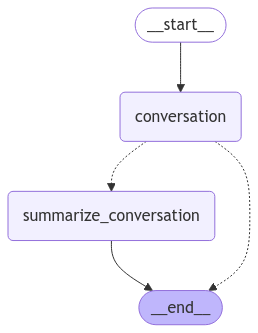

In [11]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
from dotenv import load_dotenv
load_dotenv()
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# 상태 
class State(MessagesState):
    summary: str

# 모델을 호출하는 로직 정의
def call_model(state: State):
    
    # 요약이 있으면 가져옴
    summary = state.get("summary", "")

    # 요약이 있으면 추가
    if summary:
        
        # 시스템 메시지에 요약 추가
        system_message = f"이전 대화의 요약: {summary}"

        # 새로운 메시지에 요약 추가
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # 먼저 기존 요약을 가져옴
    summary = state.get("summary", "")

    # 요약 프롬프트 생성
    if summary:
        
        # 이미 요약이 존재함
        summary_message = (
            f"지금까지의 대화 요약: {summary}\n\n"
            "위의 새로운 메시지를 고려하여 요약을 확장하세요:"
        )
        
    else:
        summary_message = "위의 대화를 요약하세요:"

    # 프롬프트를 히스토리에 추가
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # 가장 최근 2개의 메시지를 제외한 모든 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# 대화를 종료할지 요약할지 결정
def should_continue(state: State):
    
    """다음에 실행할 노드를 반환합니다."""
    
    messages = state["messages"]
    
    # 메시지가 6개 이상이면 대화를 요약
    if len(messages) > 6:
        return "summarize_conversation"
    
    # 그렇지 않으면 종료
    return END

# 새 그래프 정의
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# 시작점을 대화로 설정
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# 컴파일
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({
    "messages": [HumanMessage(content="안녕하세요")],
    "configurable": {"thread_id": "test_thread"},
    
})

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']